#### import

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import numpy as np
import csv

In [ ]:
# 设置根目录
root_dir = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0'

# 定义图像和标签的子目录
images_dir = os.path.join(root_dir, 'images-world imagery')
labels_dir = os.path.join(root_dir, 'labels 2019→2024')

# 获取所有图像文件名
image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]

num_samples = 5
fig, axs = plt.subplots(num_samples, 2, figsize=(12, num_samples * 6))

for i, img_file in enumerate(image_files[:num_samples]):
    # 构建图像和标签的完整路径
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file)  # 假设标签文件名与图像相同
    
    # 检查标签文件是否存在
    if not os.path.exists(label_path):
        print(f"标签文件 {label_path} 不存在，跳过。")
        continue
    
    # 读取图像数据
    with rasterio.open(img_path) as src:
        image_data = src.read(1)  # 读取第一波段
        transform = src.transform  # 获取地理参考信息
    
    # 读取标签数据
    with rasterio.open(label_path) as src:
        label_data = src.read(1)
    
    # 显示图像
    axs[i, 0].imshow(image_data, cmap='gray')
    axs[i, 0].set_title(f'Original Image: {img_file}')
    axs[i, 0].axis('off')
    
    # 显示标签
    axs[i, 1].imshow(label_data, cmap='gray')
    axs[i, 1].set_title(f'Label Image: {img_file}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# # 拿出文件夹中的所有图片名
# import pandas as pd

# read_dir = r'C:\Users\YANGRUYI\OneDrive\MIT senseable city lab\favela\extracting-slums-from-satellite-imagery\training_data_roiall2019_cell0.5_tile2048_stride1024\output_images\3-Ruixian'
# csv_file_path = r'image_names-3-Ruixian.csv'

# image_names = [os.path.splitext(f)[0] for f in os.listdir(read_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
# pd.DataFrame(image_names, columns=['Image Name']).to_csv(csv_file_path, index=False)

### Masking
for visualization

In [ ]:
# 输出mask, visualize, 两张并排
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
import numpy as np
import pandas as pd



# 设置根目录
root_dir = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\1-training_data_Tijuca'

# 保存图像的输出目录
output_dir = os.path.join(r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\1-training_data_Tijuca', 'output_images')
os.makedirs(output_dir, exist_ok=True)

# 定义图像和标签的子目录
images_dir = os.path.join(root_dir, 'images')
labels_dir = os.path.join(root_dir, 'labels')

# ------------------------------------------------------------------
# 获取所有图像文件名
image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]

# # only for stephania
# csv_path = 'stephania_label.csv'  
# image_files_df = pd.read_csv(csv_path)  
# image_files = image_files_df['image_name'].tolist() 
# image_files = ['000000000391.tif',
#                 '000000000073.tif',
#                 '000000000959.tif'
#                ]
# # ------------------------------------------------------------------ 

# 目标图像大小
target_size = (1024, 1024) # notice here

# num_samples = 5

for img_file in image_files: # to save 
# for i, img_file in enumerate(image_files[:num_samples]): # to visualize
    # 构建图像和标签的完整路径
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file)  # 假设标签文件名与图像相同
    
    # 检查标签文件是否存在
    if not os.path.exists(label_path):
        print(f"标签文件 {label_path} 不存在，跳过。")
        continue
    
    # 读取图像数据并缩放
    with rasterio.open(img_path) as src:
        image_data = src.read(out_shape=(src.count, *target_size), resampling=Resampling.bilinear)  # 保留彩色波段
        image_data = np.moveaxis(image_data, 0, -1)  # 调整维度，适配 matplotlib 的 RGB 显示格式
    
    # 读取标签数据并缩放
    with rasterio.open(label_path) as src:
        label_data = src.read(1, out_shape=target_size, resampling=Resampling.nearest)  # 使用最近邻插值缩放标签
    
    # 创建只包含值为1的部分的布尔掩膜
    mask = label_data == 1  #检查这个tile输出的有没有2
    
    # 创建一个mask RGBA叠加层
    overlay = np.zeros((target_size[0], target_size[1], 4))  # 创建一个与图像大小一致的空白RGBA图层
    overlay[..., 0] = 1  # 设置RGB为红色
    # overlay[..., :0] = 1  # 设置RGB为白色

    # 叠加半透明效果：在 mask 匹配区域将红色叠加到原图像
    alpha = 0.2
    overlayed_image = image_data.astype(np.float32) / 255  # 将图像转换为浮点型并归一化
    overlayed_image[mask] = overlayed_image[mask] * (1 - alpha) + overlay[mask] * alpha  # 仅在mask区域叠加红色

    overlayed_image = (overlayed_image * 255).astype(np.uint8)
    

    transparent_border = np.zeros((target_size[0], 30, 4), dtype=np.uint8) 
    # 拼接原图和叠加后的图像（在两者之间加上透明的边框）
    combined_image = np.hstack((image_data, transparent_border, overlayed_image)) 
    
    # 保存拼接后的图像
    output_path = os.path.join(output_dir, f'overlay_{os.path.splitext(img_file)[0]}_{target_size[0]}.png')
    combined_image_pil = Image.fromarray(combined_image)
    combined_image_pil.save(output_path)


    # 可选，显示原图和叠加图像并排
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # 一行两列
    axs[0].imshow(image_data)
    axs[0].axis('off')
    axs[0].set_title(f'Original Image: {img_file}')
    
    axs[1].imshow(overlayed_image)
    axs[1].axis('off')
    axs[1].set_title(f'Overlay Image (Red Mask)')

    # 二选一
    plt.show()
    # plt.close(fig)

### TIFF TO PNG

In [ ]:
root_dir = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\dataset-collage'

# 定义图像和标签的子目录
images_dir = os.path.join(root_dir, 'significant-diff-files')

In [ ]:
'''
tiff to png
please notice to adjust the color mode
'''

# image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
output_dir = os.path.join(root_dir, 'converted_images')
os.makedirs(output_dir, exist_ok=True)

# 批量转换 TIFF 为 PNG
for img_file in image_files:
    tif_path = os.path.join(images_dir, img_file)
    png_path = os.path.join(output_dir, img_file.replace('.tif', '.png'))  # 替换扩展名为 .png

    # 打开 TIFF 图像并保存为 PNG
    with Image.open(tif_path) as img:
        img = img.convert('RGB')  # change here, img.convert('RGB') 或者 img.convert('RGBA')，如果你想保留透明度 #或者img.convert('L')，如果你想保留灰度
        
        img.save(png_path, 'PNG')

print(f'转换完成，共转换 {len(image_files)} 张图像。')

In [ ]:
# from PIL import Image

# def get_image_info(image_path):
#     # 打开图片文件
#     with Image.open(image_path) as img:
#         # 获取图片的模式
#         mode = img.mode
#         # 获取所有像素值
#         pixels = list(img.getdata())
#         # 使用集合来存储唯一的颜色值
#         unique_colors = set(pixels)
#         return mode, unique_colors

# # 示例用法
# # image_path = r'E:\Workfolder\favela\favela_data\test\mask_greyscale\000000001538_png.rf.b4f8df23370ab8108cba094cde6009c5.png'
# image_path = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\converted_images\000000001024.png'
# mode, unique_colors = get_image_info(image_path)
# print(f'图片模式: {mode}')
# print(f'图片中共有 {len(unique_colors)} 种唯一颜色值。')
# print(unique_colors)

#### 将筛选的图像转移到另一个文件夹

In [ ]:
# import os
# import csv
# import shutil

# #filter images

# # Set the root and directories
# root_dir = r'G:\ArcGIS File\extracting-slums-from-satellite-imagery\4_training_data_roi_roiall2019_cell0.5_tile2048_stride1024_manually'
# images_dir = os.path.join(root_dir, 'images')
# output_dir = os.path.join(root_dir, 'images_filtered')  # Folder to move selected TIFFs
# os.makedirs(output_dir, exist_ok=True)

# # Path to CSV file containing the list of images to move
# csv_file_path = os.path.join(root_dir, 'filtered_image_list.csv')

# # Read the list of filenames to be moved from the CSV file
# with open(csv_file_path, mode='r') as csv_file:
#     reader = csv.reader(csv_file)
#     # Assuming the filenames are in the first column; adjust index if needed
#     images_to_move = {row[0].strip() for row in reader}

# # Get all TIFF files in the directory and filter based on CSV list
# image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif') and f in images_to_move]

# # Move the TIFF files to the target directory
# for img_file in image_files:
#     tif_path = os.path.join(images_dir, img_file)
#     target_path = os.path.join(output_dir, img_file)

#     # Move the file
#     shutil.move(tif_path, target_path)
#     print(f"Moved {img_file} to {output_dir}")

# print(f'Move complete. {len(image_files)} images have been moved.')


In [ ]:
#tiff to png 

tif_path = r'G:\ArcGIS File\extracting-slums-from-satellite-imagery\4_training_data_roi_roiall2019_cell0.5_tile2048_stride1024_manually\images\000000001296.tif'

with Image.open(tif_path) as img:
    img = img.convert('RGB')  # Convert to RGBA if transparency is needed
    img_resized = img.resize(target_size, Image.ANTIALIAS)
    img_resized.save('000000001296.png', 'PNG')


In [ ]:
# import os
# import numpy as np
# import tifffile as tiff
# from PIL import Image
# import csv

# # 增加逻辑
# # 1.跳过有透明部分（底图信息不完整）的图片
# # 2.resize image

# # Set root directory and folders
# root_dir = r'G:\ArcGIS File\extracting-slums-from-satellite-imagery\3_training_data_roi_roiall2019_cell0.5_tile2048_stride1024'
# images_dir = os.path.join(root_dir, 'images')  # Directory with TIFF images
# output_dir = os.path.join(root_dir, 'opaque_images')  # Directory to save fully opaque PNG images
# os.makedirs(output_dir, exist_ok=True)

# # CSV file path for transparent images log
# csv_file = os.path.join(root_dir, 'transparent_images.csv')
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Image Name', 'Transparent Percentage'])  # Write header

#     # Get all TIFF files
#     image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]

#     # Target image size
#     target_size = (1024, 1024)  # Resize images to 1024x1024

#     # Process each TIFF image
#     for img_file in image_files:
#         tif_path = os.path.join(images_dir, img_file)
#         png_path = os.path.join(output_dir, img_file.replace('.tif', '.png'))  # Convert extension to .png

#         try:
#             # Load the TIFF image using tifffile to retain transparency data if available
#             img_array = tiff.imread(tif_path)

#             # Check if the image has an alpha (transparency) channel
#             if img_array.shape[-1] == 4:
#                 # Extract the alpha channel
#                 alpha_channel = img_array[:, :, 3]
#                 transparent_pixels = np.sum(alpha_channel < 255)
                
#                 # Calculate transparency ratio
#                 total_pixels = img_array.shape[0] * img_array.shape[1]
#                 transparent_ratio = (transparent_pixels / total_pixels) * 100  # Transparency as a percentage

#                 # Record images with transparency in the CSV
#                 if transparent_pixels > 0:
#                     writer.writerow([img_file, transparent_ratio])
#                     print(f"Skipped {img_file} with {transparent_ratio:.2f}% transparent pixels.")
#                 else:
#                     # Convert image array back to PIL format for resizing and saving
#                     img = Image.fromarray(img_array).convert('RGBA')
#                     img_resized = img.resize(target_size, Image.ANTIALIAS)
                    
#                     # Save the image as PNG
#                     img_resized.save(png_path, 'PNG')
#                     print(f"Saved opaque image: {img_file}")

#             else:
#                 # If no alpha channel is present, assume image is opaque and save it
#                 img = Image.fromarray(img_array)
#                 img_resized = img.resize(target_size, Image.ANTIALIAS)
#                 img_resized.save(png_path, 'PNG')
#                 print(f"Saved opaque image (no alpha channel): {img_file}")

#         except Exception as e:
#             print(f"Error processing {img_file}: {e}")

# print(f'Conversion complete. Transparent images logged in {csv_file}.')


In [ ]:
import tifffile as tiff

# Load the TIFF file using tifffile to check if we can access transparency information directly

# Load the image with tifffile
img_array = tiff.imread(tif_path)

# Check the shape of the image array to determine if there's an additional channel
img_shape = img_array.shape

# If it has an extra channel, calculate the transparency ratio based on that channel
if img_shape[-1] == 4:  # Assuming last channel could be an alpha/transparency channel
    alpha_channel = img_array[:, :, 3]
    transparent_pixels = np.sum(alpha_channel < 255)
    total_pixels = img_array.shape[0] * img_array.shape[1]
    transparent_ratio = (transparent_pixels / total_pixels) * 100  # Transparency as a percentage
else:
    transparent_ratio = 0  # No fourth channel detected, assume no transparency

transparent_ratio  # Output the calculated transparent percentage


### convert to  coco dataset

run this code directly

In [ ]:
import os
import cv2
import numpy as np
import rasterio
import json

# 加入逻辑：
# 1. scale_factor 
# 2. 需要会有至少一个有效的（忽略太小的）mask
#   2.1 contour需要>3个点 -- 忽略太小的mask
#   2.2 contour(mask)占总图像面积的比例需要达到 x% -- 可以选择性忽略
# 3. 只将符合条件的tif图像转化为png

scale_factor = 1 ##注意

# 创建目标输出目录
output_dir = os.path.join(root_dir, 'converted_images_0.1maskratiotheshold')
os.makedirs(output_dir, exist_ok=True)

# COCO格式的初始化
coco_format = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "slum", "supercategory": "none"}]
}

image_id = 1
annotation_id = 1

# 遍历所有图片文件
for img_file in image_files:
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file)
    
    if not os.path.exists(label_path):
        continue
    
    with rasterio.open(label_path) as src:
        label_data = src.read(1)
        height, width = image_data.shape
    
    label_data = label_data.astype(np.uint8)
    _, binary_mask = cv2.threshold(label_data, 0, 255, cv2.THRESH_BINARY) 
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if len(contour) >= 3 :  # 过滤条件 and area / (height * width) >= 0.1
            valid_contours.append(contour)
    
    # 如果没有有效的轮廓，跳过这张图像
    if len(valid_contours) == 0:
        continue
    
    # 获取图像的宽高信息
    with rasterio.open(img_path) as src:
        image_data = src.read(1)
        height, width = image_data.shape
    
    # 将该图像加入到COCO格式的images中
    coco_format["images"].append({
        "id": image_id,
        "file_name": os.path.splitext(img_file)[0] + ".png",  # 后缀由.tif改为.png
        "width": int(width * scale_factor),
        "height": int(height * scale_factor)
    })
    
    # 处理有效的轮廓并加入到COCO的annotations中
    for contour in valid_contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Scale the bounding box and area
        x, y, w, h = x * scale_factor, y * scale_factor, w * scale_factor, h * scale_factor
        area = area * scale_factor ** 2  # Adjust the area
        
        segmentation = [list(np.array(contour).flatten() * scale_factor)]  # 将轮廓数据转换为列表形式
        
        coco_format["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": 1,
            "bbox": [x, y, w, h],
            "area": area,
            "iscrowd": 0,
            "segmentation": segmentation
        })
        annotation_id += 1
    
    # 转换原始图像为PNG格式并保存
    png_path = os.path.join(output_dir, img_file.replace('.tif', '.png'))  # 替换扩展名为 .png

    # 打开 TIFF 图像并保存为 PNG
    with Image.open(img_path) as img:
        img = img.convert('RGB')  # 或者 img.convert('RGBA')，如果你想保留透明度
        img = img.resize((int(width * scale_factor), int(height * scale_factor)), Image.LANCZOS)  #optional,压缩图片
        img.save(png_path, 'PNG')


    # png_path = os.path.join(output_dir, img_file.replace('.tif', '.png'))
    # with rasterio.open(img_path) as src:
    #     image_data = src.read([1, 2, 3])  # 读取图像的三个通道 (RGB)
    #     image_data = np.moveaxis(image_data, 0, -1)  # 转换为 H, W, C 格式
    #     cv2.imwrite(png_path, image_data)
    
    # 更新image_id，准备处理下一张图像
    image_id += 1




In [ ]:
# import json
# import numpy as np

# # 设置缩放因子
# scale_factor = 0.5

# # 加载原始 JSON 文件
# json_path = r'G:\ArcGIS File\extracting-slums-from-satellite-imagery\3_training_data_roi_roiall2019_cell0.5_tile2048_stride1024\cocodataset\annotations.json'

# with open(json_path, 'r') as f:
#     coco_format = json.load(f)

# # 调整 annotations 中的参数
# for annotation in coco_format["annotations"]:
#     # 获取 bbox 参数，并根据缩放因子进行调整
#     bbox = annotation["bbox"]
#     bbox[0] *= scale_factor  # x
#     bbox[1] *= scale_factor  # y
#     bbox[2] *= scale_factor  # w
#     bbox[3] *= scale_factor  # h
#     annotation["bbox"] = bbox
    
#     # 调整 area 参数
#     area = annotation["area"]
#     annotation["area"] = area * scale_factor * scale_factor  # 调整面积
    
#     # 如果有 segmentation，则对每个点进行缩放
#     if "segmentation" in annotation:
#         for seg in annotation["segmentation"]:
#             # 对每个点进行缩放
#             seg = [coord * scale_factor for coord in seg]
#             annotation["segmentation"] = [seg]

# # 保存修改后的 JSON 文件
# output_json_path = r'G:\ArcGIS File\extracting-slums-from-satellite-imagery\3_training_data_roi_roiall2019_cell0.5_tile2048_stride1024\cocodataset\annotations_resized.json'
# with open(output_json_path, 'w') as f:
#     json.dump(coco_format, f)

# print(f"Updated JSON file saved to {output_json_path}")


In [ ]:
# Function to recursively convert NumPy types to Python types
def convert_to_json_serializable(obj):
    if isinstance(obj, np.ndarray):  # Convert NumPy arrays to Python lists
        return obj.tolist()
    elif isinstance(obj, (np.int32, np.int64)):  # Convert NumPy integers to Python int
        return int(obj)
    elif isinstance(obj, (np.float32, np.float64)):  # Convert NumPy floats to Python float
        return float(obj)
    elif isinstance(obj, dict):  # Recursively process dictionaries
        return {key: convert_to_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):  # Recursively process lists
        return [convert_to_json_serializable(item) for item in obj]
    return obj  # Return the object itself if no conversion is needed

# At the final step, before saving the JSON:
json_output_path = os.path.join(root_dir, 'annotations.json')

# Convert the COCO format to JSON-serializable format
coco_format_serializable = convert_to_json_serializable(coco_format)

# Save the cleaned data to a JSON file
with open(json_output_path, 'w', encoding='utf-8') as f:
    json.dump(coco_format_serializable, f, ensure_ascii=False, indent=4)

print(f"COCO格式的JSON文件已保存到: {json_output_path}")


In [ ]:
# # 将COCO格式的数据保存为JSON文件
# json_output_path = os.path.join(root_dir, 'annotations.json')
# with open(json_output_path, 'w', encoding='utf-8') as f:
#     json.dump(coco_format, f, ensure_ascii=False, indent=4)
# print(f"COCO格式的JSON文件已保存到: {json_output_path}")

### uploade image to roboflow

In [ ]:
! pip install roboflow

In [ ]:
! roboflow login

In [ ]:
! roboflow import -w my-first-workspace-list1 -p is-favela-2048to1024-only-mask "G:/ArcGIS File/extracting-slums-from-satellite-imagery/3_training_data_roi_roiall2019_cell0.5_tile2048_stride1024/cocodataset"

In [ ]:
# Install
! pip install roboflow

# Authenticate
! roboflow authenticate

# Import
! roboflow import -w my-second-workspace-for-favela -p ss_rio_tile1024_stride0 r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\coco_dataset\2019'

In [ ]:
import roboflow

rf = roboflow.Roboflow(api_key="sRBH2PAnkPFSD53Ai589")

# project = rf.workspace("my-first-workspace-list1").project("is-favela-2048to1024-only-mask-drguu")

# get a workspace
workspace = rf.workspace("my-first-workspace-list1")

# Upload data set to a new/existing project
workspace.upload_dataset(
    "G:/ArcGIS File/extracting-slums-from-satellite-imagery/3_training_data_roi_roiall2019_cell0.5_tile2048_stride1024/cocodataset", # This is your dataset path
    "is-favela-2048to1024-only-mask-drguu", # This will either create or get a dataset with the given ID
    num_workers=10,
    project_license="MIT",
    project_type="object-detection",
    batch_name=None,
    num_retries=0
)

### coco json分成train和val集

In [ ]:
import json
import os

# 加载原始 JSON 文件
with open(os.path.join(root_dir, 'coco_format.json'), 'r') as f:
    coco_data = json.load(f)

# 创建新的 JSON 字典
train_data = {
    "licenses": coco_data.get("licenses", []),
    "info": coco_data.get("info", {}),
    "images": [],
    "annotations": [],
    "categories": coco_data.get("categories", [])
}

val_data = {
    "licenses": coco_data.get("licenses", []),
    "info": coco_data.get("info", {}),
    "images": [],
    "annotations": [],
    "categories": coco_data.get("categories", [])
}

# 设置分割标界限
val_boundary = '000000000754.png'

# 拆分图像和标注
for image in coco_data['images']:
    if image['file_name'] <= val_boundary:
        train_data['images'].append(image)
    else:
        val_data['images'].append(image)

# 处理标注
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    for image in coco_data['images']:
        if image['id'] == image_id:
            if image['file_name'] <= val_boundary:
                train_data['annotations'].append(annotation)
            else:
                val_data['annotations'].append(annotation)

# 保存训练集和验证集的 JSON 文件
with open(os.path.join(root_dir, 'train_coco_format.json'), 'w') as f:
    json.dump(train_data, f, indent=4)

with open(os.path.join(root_dir, 'val_coco_format.json'), 'w') as f:
    json.dump(val_data, f, indent=4)

print("数据集已拆分为 train 和 val。")


In [ ]:
import json
from collections import defaultdict

# 加载 COCO 格式的 JSON 文件
json_file_path = os.path.join(root_dir, 'val_coco_format.json')  # 替换为您的文件路径

with open(json_file_path, 'r') as f:
    coco_data = json.load(f)

# 创建一个字典来跟踪 ID 的出现次数
id_counts = defaultdict(int)

# 遍历注释并计算每个 ID 的出现次数
for annotation in coco_data['annotations']:
    annotation_id = annotation['id']
    id_counts[annotation_id] += 1

# 检查哪些 ID 是重复的
duplicate_ids = {id: count for id, count in id_counts.items() if count > 1}

# 输出重复的 ID
if duplicate_ids:
    print("以下 ID 在 annotations 中是重复的：")
    for id, count in duplicate_ids.items():
        print(f"ID: {id}, 计数: {count}")
else:
    print("所有 annotation 的 ID 都是唯一的。")


In [ ]:
# 读取标签数据并确保是单通道图像
with rasterio.open(label_path) as src:
    label_data = src.read(1)  # 读取第一波段

# 确保标签数据是 uint8 格式
label_data = label_data.astype(np.uint8)

# 进行二值化处理，假设非零区域是对象
_, binary_mask = cv2.threshold(label_data, 0, 255, cv2.THRESH_BINARY) # 0 as the threshold,像素值大于指定的阈值（在本例中为 1），它就会被设置为最大值（255），否则设置为 0

# 找到轮廓
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 打印轮廓数量
print(f'找到 {len(contours)} 个轮廓')

# 可视化轮廓
for contour in contours:
    cv2.drawContours(label_data, [contour], -1, (255, 0, 0), 2)  

plt.imshow(label_data, cmap='gray')
plt.title('Contours on Label Image')
plt.axis('off')
plt.show()


In [ ]:
import rasterio

# 设置标签文件路径
label_file = r'E:\ArcGIS File\extracting-slums-from-satellite-imagery\training_data_Tijuca\labels\000000000000.tif'  # 替换为您的标签文件路径

# 打开标签图像
with rasterio.open(label_file) as src:
    label_data = src.read()  # 读取所有波段

print("标签图像的形状:", label_data.shape)

In [ ]:
import geopandas as gpd
from shapely.geometry import box

# 读取矢量数据
gdf = gpd.read_file(r"E:\QGIS\rio favela\extracted.gpkg")

# 获取数据的总边界
minx, miny, maxx, maxy = gdf.total_bounds

# 计算1024x1024图块大小（假设CRS为米，或根据实际情况调整）
tile_size = 1024  # 1024 units, adjust according to CRS units (e.g., meters, degrees)

# 创建网格并裁剪
for x in range(int(minx), int(maxx), tile_size):
    for y in range(int(miny), int(maxy), tile_size):
        # 创建一个1024x1024的矩形网格
        tile = box(x, y, x + tile_size, y + tile_size)
        tile_gdf = gpd.GeoDataFrame([1], geometry=[tile], crs=gdf.crs)
        
        # 裁剪矢量数据
        clipped = gpd.clip(gdf, tile_gdf)

        # 保存裁剪后的矢量数据
        if not clipped.empty:
            clipped.to_file(f"tile_{x}_{y}.gpkg", driver="GPKG")


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取 GeoPackage 文件
file_path = r"E:\QGIS\rio favela\extracted_pseudo.gpkg"

# 尝试读取第一个图层（如果你只关心第一个图层）
gdf = gpd.read_file(file_path)

# 绘制图层
gdf.plot()

# 设置绘图标题
plt.title("Plot of extracted.gpkg")
plt.show()


In [ ]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

# 读取 TIF 文件
tif_file = r"E:\QGIS\rio favela\vector.tif"

# 使用 rasterio 读取 tif 文件
with rasterio.open(tif_file) as src:
    # 读取第一个波段的数据
    img = src.read(1)

    # 绘制图像
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='viridis')
    plt.colorbar()
    plt.title("Plot of extracted_pseudo.tif")
    plt.xlabel("X 坐标")
    plt.ylabel("Y 坐标")
    plt.show()


In [ ]:
import geopandas as gpd
from shapely.geometry import box

# 读取矢量数据
gdf = gpd.read_file(r"E:\QGIS\rio favela\extracted_pseudo.gpkg")

# 获取数据的总边界
minx, miny, maxx, maxy = gdf.total_bounds

minx, miny, maxx, maxy 

In [ ]:
print(gdf.crs)

In [ ]:
from PIL import Image

# 禁用 Pillow 的像素限制
Image.MAX_IMAGE_PIXELS = None

# 读取PNG图像
image_path = r"E:\QGIS\rio favela\Oct092019_Tijuca.png"  # 替换为你的PNG图像路径
img = Image.open(image_path)

# 获取图像的尺寸 (宽度和高度)
width, height = img.size
print(f"Image size: {width} x {height}")


## archive

In [ ]:
'''
对一个文件夹中所有mask（0，1） 转换为范围为 0 和 255 的格式
'''

# Function to process all PNG files in a folder
def convert_masks_in_folder(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".png"):  # Only process PNG files
            input_path = os.path.join(input_folder, filename)
            trimmed_filename = filename.replace("_mask", "")
            output_path = os.path.join(output_folder, trimmed_filename)
            
            # Load the image and convert it
            image = Image.open(input_path)
            image_array = np.array(image)
            converted_image = (image_array * 255).astype(np.uint8)
            
            # Save the converted image to the output folder
            Image.fromarray(converted_image).save(output_path)
            print(f"Processed: {filename} -> {output_path}")

# Specify the input and output folder paths
input_folder = r"H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels 2019→2024 binary"
output_folder = r"H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels 2019→2024 binary_greyscale"

# Execute the batch processing
convert_masks_in_folder(input_folder, output_folder)


In [ ]:
import os
from PIL import Image, ImageDraw, ImageFont


def stitch_images(image_paths, folder_names, output_path, scale_factor=0.5):
    # 打开所有图像并获取它们的尺寸
    images = []
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        if i >= 2:  # 后两个文件夹中的tif文件转换为binary图像
            img = img.convert('L')
            img = img.point(lambda p: 255 if p == 1 else p)
        # 缩小图像大小
        img = img.resize((int(img.width * scale_factor), int(img.height * scale_factor)))
        images.append(img)
    
    widths, heights = zip(*(img.size for img in images))

    # 计算拼接后的图像尺寸
    total_width = sum(widths)
    max_height = max(heights) + 30  # 为图注预留空间

    # 创建一个新的空白图像
    stitched_image = Image.new('RGB', (total_width, max_height), (255, 255, 255))

    # 将每张图像粘贴到新图像中
    x_offset = 0
    for img in images:
        stitched_image.paste(img, (x_offset, 0))
        x_offset += img.width

    # 添加图注
    draw = ImageDraw.Draw(stitched_image)
    font = ImageFont.load_default()
    x_offset = 0
    for folder_name in folder_names:
        # text_width, text_height = draw.textsize(folder_name, font=font)
        bbox = draw.textbbox((0, 0), folder_name, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        text_x = x_offset + (widths[folder_names.index(folder_name)] - text_width) // 2  # 去掉左偏移
        text_y = max_height - 20
        draw.text((text_x, text_y), folder_name, (0, 0, 0), font=font)
        x_offset += widths[folder_names.index(folder_name)]

    # 保存拼接后的图像
    stitched_image.save(output_path)

In [ ]:
# 示例用法
folders = [
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\images[2019]',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\images[world imagery]',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2013to2019]',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2019to2024]'
]

# 以第一个文件夹为蓝本
base_folder = folders[0]
base_filenames = [f for f in os.listdir(base_folder) if f.endswith('.tif')]
len(base_filenames)

In [ ]:
''''为了找到三个文件夹中图片名称的交集'''
import csv

folders = [
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2013to2019]',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2008]_matched_files',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2019to2024]_matched_files'
]

# 获取每个文件夹中的所有文件名
file_sets = []
for folder in folders:
    file_names = set(os.listdir(folder))
    file_sets.append(file_names)

# 计算文件名的交集
common_files = set.intersection(*file_sets)

print(len(common_files))

csv_file_path = 'common_files.csv'

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['File Name'])  # 写入表头
    for file_name in common_files:
        writer.writerow([file_name])

print(f"Common files have been saved to {csv_file_path}")

In [ ]:

output_dir = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\dataset-collage'
os.makedirs(output_dir, exist_ok=True)

folders = [
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\images[2019]',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\images[world imagery]',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2008]_matched_files',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2013to2019]',
    r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2019to2024]_matched_files'
]

for filename in common_files: # notice here
    paths = [os.path.join(folder, filename) for folder in folders if os.path.exists(os.path.join(folder, filename))]
    if len(paths) == len(folders):  # 确保所有文件夹中都有同名文件
        output_path = os.path.join(output_dir, filename)
        stitch_images(paths, [os.path.basename(folder) for folder in folders], output_path, scale_factor=0.5)

print('拼接完成。')

In [ ]:
import os
import shutil
import rasterio

# 文件夹路径
folder1 = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2013to2019]'
folder2 = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels 2008'
target_folder = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2008]_matched_files'

# 创建目标文件夹
os.makedirs(target_folder, exist_ok=True)

# 获取文件夹中的所有 TIFF 文件
tif_files1 = [f for f in os.listdir(folder1) if f.endswith('.tif')]
tif_files2 = [f for f in os.listdir(folder2) if f.endswith('.tif')]

# 读取第一个文件夹中的 TIFF 文件的左上角坐标
coords1 = {}
for tif_file in tif_files1:
    with rasterio.open(os.path.join(folder1, tif_file)) as dataset:
        bounds = dataset.bounds
        top_left = (bounds.left, bounds.top)
        coords1[top_left] = tif_file
print("finishing reading the first folder's geo information")

# 读取第二个文件夹中的 TIFF 文件的左上角坐标，并进行匹配
for tif_file in tif_files2:
    # print(tif_file)
    with rasterio.open(os.path.join(folder2, tif_file)) as dataset:
        bounds = dataset.bounds
        top_left = (bounds.left, bounds.top)
        adjusted_top_left = (top_left[0] - 0.12193140760064125, top_left[1] - 0.30752158537507057) # notice only for 2008
        if adjusted_top_left in coords1:
            # 匹配成功，重命名并移动文件
            new_name = coords1[adjusted_top_left]
            dataset.close()  # 确保文件关闭
            shutil.move(os.path.join(folder2, tif_file), os.path.join(target_folder, new_name))
            # print(f"Moved and renamed {tif_file} to {new_name}")
        else: # 未找到匹配项
            print(f"No match found for {tif_file}")

print("Processing complete.")

In [ ]:
import os
import rasterio
import math

'''每个 TIFF 文件左上角坐标与给定坐标 (-4828005.81, -2611731.05) 之间的欧几里得距离，然后找出距离最小的文件'''
# target_coord = (-4828005.81, -2611731.05)
target_coord = (-4823728.22310397,-2608334.615470536) # label 1999

folder1 = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\labels[2013to2019]'

# 获取文件夹中的所有 TIFF 文件
tif_files1 = [f for f in os.listdir(folder1) if f.endswith('.tif')]

# 读取第一个文件夹中的 TIFF 文件左上角坐标
coords1 = {}
for tif_file in tif_files1:
    with rasterio.open(os.path.join(folder1, tif_file)) as dataset:
        bounds = dataset.bounds
        top_left = (bounds.left, bounds.top)
        coords1[top_left] = tif_file
print("Finished reading the first folder's geo information")

# 计算每个 TIFF 文件左上角坐标与给定坐标之间的距离
def euclidean_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

# 创建一个列表存储每个文件的距离和文件名
distances = []

for coord, tif_file in coords1.items():
    distance = euclidean_distance(coord, target_coord)
    distances.append((distance, tif_file))

# 按距离排序
distances.sort(key=lambda x: x[0])

# 获取前5近的文件
closest_files = distances[:5]

# 输出前5近的文件名称和距离
for i, (distance, tif_file) in enumerate(closest_files, start=1):
    print(f"{i}: {tif_file} with distance {distance}")




In [ ]:
import csv
import os
import shutil

# 定义输入 CSV 文件路径和源文件夹路径
csv_file_path = 'output_directory/temp_output/significant_diff_files.csv'
source_folder = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\dataset-collage'
destination_folder = r'H:\ArcGIS File\extracting-slums-from-satellite-imagery\5_training_data_rio_rio2019&2024_cell0.5_tile2024_stride0\dataset-collage\significant-diff-files'

# 创建目标文件夹（如果不存在）
os.makedirs(destination_folder, exist_ok=True)

# 读取 CSV 文件中的文件名
file_names = []
with open(csv_file_path, newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        file_names.append(row[0])

# 拷贝文件到目标文件夹
for file_name in file_names:
    source_file = os.path.join(source_folder, file_name)
    destination_file = os.path.join(destination_folder, file_name)
    if os.path.exists(source_file):
        shutil.copy(source_file, destination_file)
        print(f"Copied {file_name} to {destination_folder}")
    else:
        print(f"File {file_name} does not exist in {source_folder}")

In [ ]:

'''
mask difference
并分别比较第3和第4个文件、第4和第5个文件的差异是否达到5%
'''

def check_mask_difference(mask1_path, mask2_path):
    mask1 = Image.open(mask1_path).convert('L')
    mask2 = Image.open(mask2_path).convert('L')
    
    # 计算差异
    diff = np.array(mask1) - np.array(mask2)
    diff = np.where(diff > 0, 255, 0)  # 只保留白色部分的差异
    
    # 计算差异的比例
    diff_ratio = np.sum(diff > 0) / diff.size
    
    return diff_ratio 

significant_diff_files = []
threshold=0.1

for filename in common_files:
    # print(filename)
    paths = [os.path.join(folder, filename) for folder in folders if os.path.exists(os.path.join(folder, filename))]
    if len(paths) == len(folders):  # 确保所有文件夹中都有同名文件
        # 检查第3和第4个文件的掩码差异
        diff_3_4 = check_mask_difference(paths[2], paths[3])
        # 检查第4和第5个文件的掩码差异
        diff_4_5 = check_mask_difference(paths[3], paths[4])
        
        if diff_3_4 > threshold or diff_4_5 > threshold:
            print(f"{filename} has significant difference")
            significant_diff_files.append((filename, diff_3_4, diff_4_5))

# 保存有显著差异的文件名和差异值
output_dir = 'output_directory'  # 请根据实际情况修改
os.makedirs(os.path.join(output_dir, 'temp_output'), exist_ok=True)
with open(os.path.join(output_dir, 'temp_output/significant_diff_files.txt'), 'w') as f:
    f.write("Filename,Diff_3_4,Diff_4_5\n")
    for filename, diff_3_4, diff_4_5 in significant_diff_files:
        f.write(f"{filename},{diff_3_4},{diff_4_5}\n")


# 000000003535.tif 这个是典型的
# 000000007452.tif 为什么不算是有明显差异的

000000003518.tif为例子去看

-- 不要用ArcGIS?

label 2019 就是没有对应上
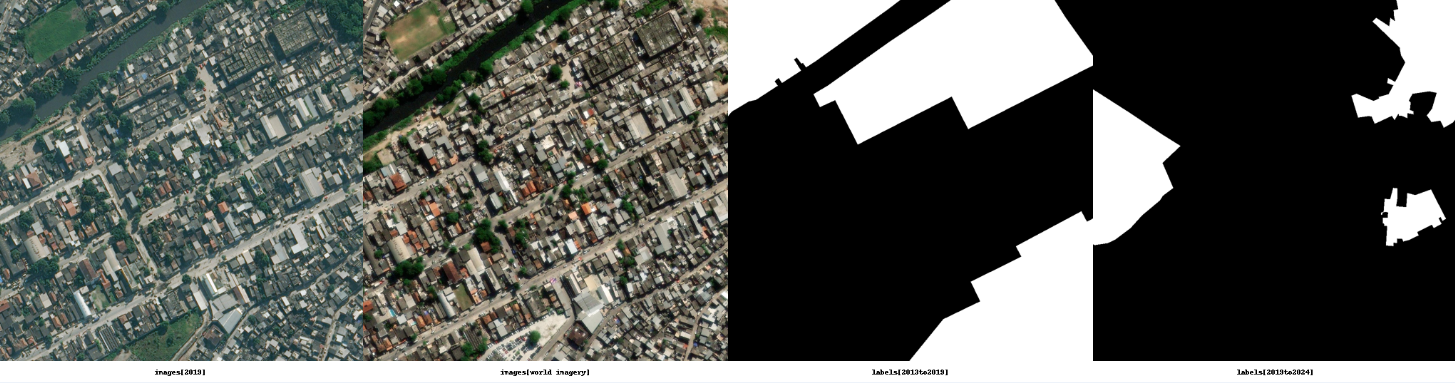


检查数据集 这个感觉看上去就没对呀

In [ ]:
# import arcpy
# import os

# # 输入文件路径
# fishnet = "inference/clip\Grid_SlumBoundary.shp" # Fishnet 文件，每个单元为正方形
# input_vector = "inference/clip/Limite_Favelas_2019.shp" # 要裁剪的矢量文件
# output_folder = "inference/clip/output"  # 输出文件夹路径
# cell_size = 0.5  # 设置栅格分辨率

# # 创建输出文件夹
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # 为 Fishnet 添加唯一的 TileID 字段（如不存在）
# if "TileID" not in [f.name for f in arcpy.ListFields(fishnet)]:
#     arcpy.management.AddField(fishnet, "TileID", "TEXT")
#     with arcpy.da.UpdateCursor(fishnet, ["OID@", "TileID"]) as cursor:
#         for row in cursor:
#             row[1] = f"tile_{row[0]:04d}"  # 格式：tile_0001, tile_0002...
#             cursor.updateRow(row)

# # 步骤 1：将矢量数据栅格化
# rasterized_vector = os.path.join(output_folder, "rasterized_vector.tif")
# arcpy.conversion.PolygonToRaster(
#     in_features=input_vector,
#     value_field="FID",  # 可以选择一个字段值作为栅格值
#     out_rasterdataset=rasterized_vector,
#     cell_assignment="MAXIMUM_AREA",
#     priority_field="NONE",
#     cellsize=cell_size
# )
# print("矢量文件已成功栅格化。")

# # 步骤 2：按 Fishnet 裁剪栅格
# with arcpy.da.SearchCursor(fishnet, ["TileID", "SHAPE@"]) as cursor:
#     for tile_id, geometry in cursor:
#         # 定义输出路径
#         output_raster_path = os.path.join(output_folder, f"{tile_id}.tif")
        
#         # 执行裁剪
#         arcpy.management.Clip(
#             in_raster=rasterized_vector,
#             rectangle=f"{geometry.extent.XMin} {geometry.extent.YMin} {geometry.extent.XMax} {geometry.extent.YMax}",
#             out_raster=output_raster_path,
#             clipping_geometry="NONE",
#             maintain_clipping_extent=True
#         )
#         print(f"裁剪完成：{tile_id}")

# print("所有裁剪完成，栅格文件已保存为 .tif 格式。")


1315
1315
1327 2019label 为什么多出来这么多 - 直接删掉
1315

这个数据集 我的天呐
